In [1]:
import badgers


# Creating a (tabular_data) generator: Scenario

Imagine we want to create an generator that multiplies values in a dataframe with some Poisson noise (don't ask me why).

That is we have some data X and we want to generate X * noise where noise comes from a Poisson distribution. Just to add some spices, we first want to standardize X, then apply the noise, and finally we want to come back to the initial scales (i.e., we inverse the standardization).

We will leave y alone for this example.

# Create the generator class

First each generator inherits form the GeneratorMixin (so we need to import it first)

This enforces the generator to implement a `generate(X, y, **params)` function

In [2]:
from badgers.core.base import GeneratorMixin

In [3]:
class MyGenerator(GeneratorMixin):

    def __init__(self):
        """Constructor code goes here"""
        pass

    def generate(self, X, y, **params):
        """Generate code goes here"""
        pass

# Add a random generator 

That is just best practice so that we can seed the random number generator and reproduce the generation

We add it to the constructor code, give it a type hint (it should be a numpy.random.Generator object) and the default value is the default_rng from numpy with seed = 0

In [4]:
import numpy as np
from numpy.random import default_rng

In [5]:
class MyGenerator(GeneratorMixin):

    def __init__(self, random_generator:np.random.Generator=default_rng(seed=0)):
        """
        :param random_generator: A random generator
        """
        self.random_generator = random_generator

    def generate(self, X, y, **params):
        """Generate code goes here"""
        pass

# Preprocess the inputs

As a convention for tabular data generators, X is expected to be a pandas DataFrame object.

Note that badgers implements a utility to preprocess inputs such as lists, list of lists, numpy arrays and convert them to pandas DataFrame. So that a user can actually input other data types than just pandas DataFrame.

This utility comes in the form of a decorator and is called `preprocess_inputs`.

It can be imported from `badgers.core.decorators.tabular_data`.

Let's add it to the `generate(X, y, **params)` function.

This will make sure that X is always a pandas DataFrame (and y is a pandas Series, but for now it does not play a role, since we are not transforming y)

In [6]:
from badgers.core.decorators.tabular_data import preprocess_inputs

In [7]:
class MyGenerator(GeneratorMixin):

    def __init__(self, random_generator:np.random.Generator=default_rng(seed=0)):
        """
        :param random_generator: A random generator
        """
        self.random_generator = random_generator

    @preprocess_inputs
    def generate(self, X, y, **params):
        """Generate code goes here"""
        pass

# Add the code to transform/generate the data.

The generation algorithm goes like this:
- first standardize X (mean = 0, standard deviation = 1).
- apply the noise (in our case we multiply X with noise, where noise ~ Poisson distriution).
- finally de-standardise to go back to the initial scales of X


We are going to use the StandardScaler from scikit-learn to standardize and "de"-standardize our data.

We are going to use numpy for the Poisson distribution (for that we use the `random_generator` object).

In [8]:
from sklearn.preprocessing import StandardScaler


In [9]:
class MyGenerator(GeneratorMixin):

    def __init__(self, random_generator:np.random.Generator=default_rng(seed=0)):
        """
        :param random_generator: A random generator
        """
        self.random_generator = random_generator

    @preprocess_inputs
    def generate(self, X, y, **params):
        """Generate code goes here"""
        # instanciating a StandardScaler object to standardize X and "de"-standardize X
        scaler = StandardScaler()
        Xt = scaler.fit_transform(X)
        # Generate some noise from the Poisson distribution
        noise = self.random_generator.poisson(size=X.shape)
        # multiply Xt with noise
        Xt *= noise
        # inverse the standardization transformation
        Xt = scaler.inverse_transform(Xt)
        # cast Xt to a pandas DataFrame
        Xt = pd.DataFrame(data=Xt, columns=X.columns, index=X.index)
        # return Xt and y
        return Xt, y


# Let's try it

First, we generate some data using sklearn make_blob utility.

Second, we instantiate our generator and apply the generate function on our data.

Finally, we plot the data using seaborn (or matplotlib or plotly, or bokeh...)

## Create some fake data and plot it

In [10]:
from sklearn.datasets import make_blobs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# create a seed that will be used all along
seed = 12345

In [12]:
# let's make some fake data

X, y = make_blobs(centers=4, random_state=seed, cluster_std=0.5)

# cast to pandas DataFrame (just for convenience)
X = pd.DataFrame(data=X, columns=['dimension_0', 'dimension_1'])
y = pd.Series(y, name='labels')

<Axes: xlabel='dimension_0', ylabel='dimension_1'>

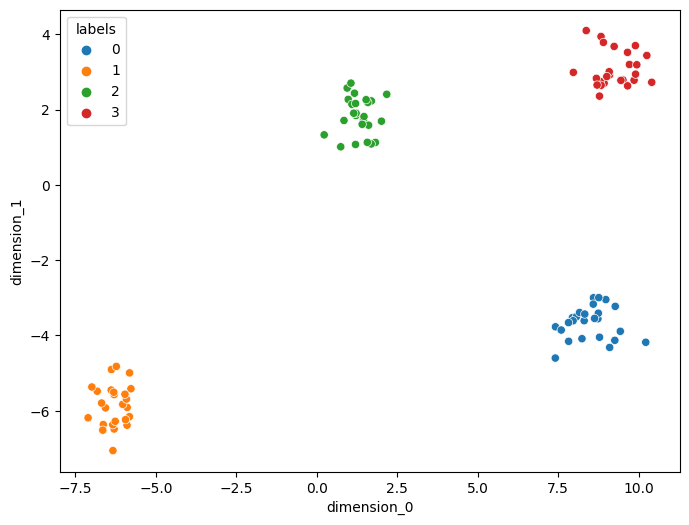

In [13]:
# plot the data
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=X, x='dimension_0', y='dimension_1', hue=y, palette=sns.color_palette('tab10')[:4], ax=ax)

## Instantiate our generator

In [14]:
# setting the random generator with our previous seed
random_generator = default_rng(seed=seed)
generator = MyGenerator(random_generator=random_generator)

## Transforming the data

In [15]:
# we create a copy of X and y because our generator acutally changes X and (potentially) y
Xt, yt = generator.generate(X=X.copy(), y=y.copy())

In [16]:
# Some sanity checks:

# y and yt should contain the same values since we haven't touch anything in y
assert all(y==yt)

# Xt should be a pandas DataFrame
assert type(Xt) is pd.DataFrame

# X and Xt should have the same shape
assert X.shape == Xt.shape

# X and Xt should also have the same columns
assert all(X.columns == Xt.columns)

## Plot the initial and the transformed data

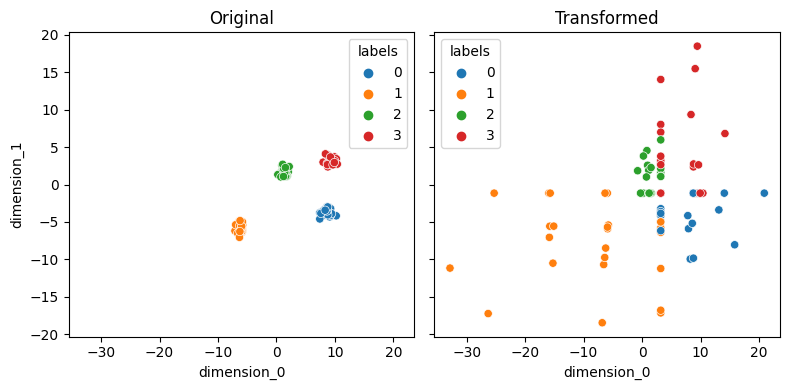

In [17]:
# plot the data
fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
sns.scatterplot(data=X, x='dimension_0', y='dimension_1', hue=y, palette=sns.color_palette('tab10')[:4], ax=axes[0])
sns.scatterplot(data=Xt, x='dimension_0', y='dimension_1', hue=yt, palette=sns.color_palette('tab10')[:4], ax=axes[1])
axes[0].set_title('Original')
axes[1].set_title('Transformed')
plt.tight_layout()

# Let's add some parameters

The poisson function from numpy has a parameter `lam` we can include it in our generate function.



In [18]:
from typing import Tuple

class MyGenerator(GeneratorMixin):
    """
    A generator that multiplies our values with some noise that follows a Poisson distribution (we could name it PoissonMultiplicativeNoiseGenerator)
    """

    def __init__(self, random_generator:np.random.Generator=default_rng(seed=0)):
        """
        :param random_generator: A random generator
        """
        self.random_generator = random_generator

    @preprocess_inputs
    def generate(self, X: pd.DataFrame, y:pd.Series, lam:float=1.) -> Tuple[pd.DataFrame,pd.Series]:
        """
        It first standardizes the X values, applies the multiplicative Poisson noise, then "de"-standardizes the values
        :param X: our input values (pd.DataFrame)
        :param y: not used (just there for API convention) could be classes labels, target values or - as in our cases - None
        :param lam: the am parameter from `numpy.random.Generator.poisson` see https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.poisson.html
        : return Xt, yt the transformed X and y
        """
        # instanciating a StandardScaler object to standardize X and "de"-standardize X
        scaler = StandardScaler()
        Xt = scaler.fit_transform(X)
        # Generate some noise from the Poisson distribution
        noise = self.random_generator.poisson(size=X.shape, lam=lam)
        # multiply Xt with noise
        Xt *= noise
        # inverse the standardization transformation
        Xt = scaler.inverse_transform(Xt)
        # cast Xt to a pandas DataFrame
        Xt = pd.DataFrame(data=Xt, columns=X.columns, index=X.index)
        # return Xt and y
        return Xt, y


## Instantiate the generator, generate data with different `lam` values and plot the results

In [19]:
generator = MyGenerator()

In [20]:
Xt_lam1, yt_lam1 = generator.generate(X=X.copy(), y=y.copy(), lam=1.)
Xt_lam2, yt_lam2 = generator.generate(X=X.copy(), y=y.copy(), lam=2.)
Xt_lam5, yt_lam5 = generator.generate(X=X.copy(), y=y.copy(), lam=5.)

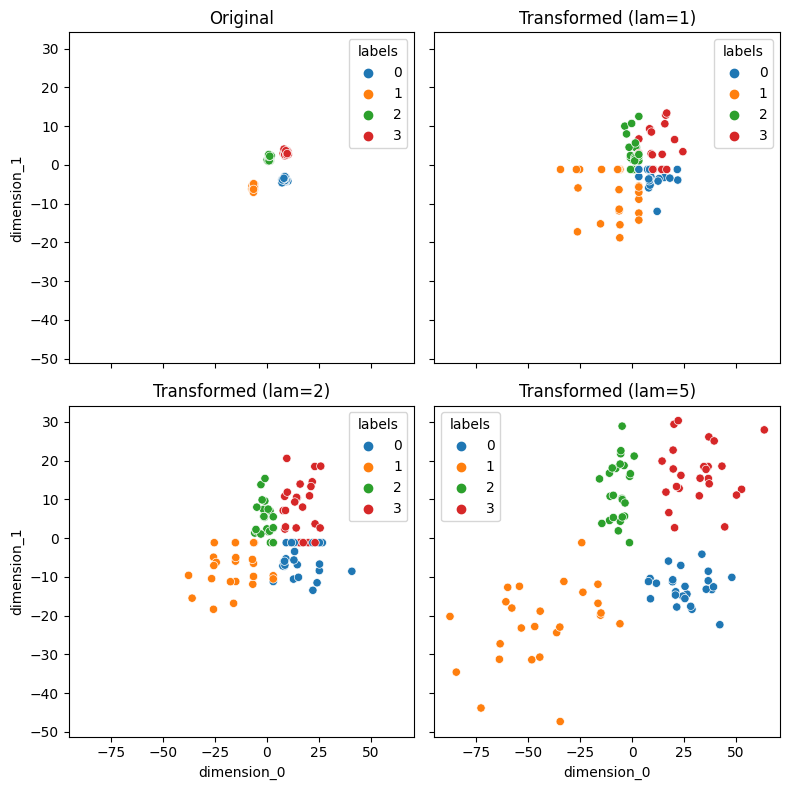

In [21]:
# plot the data
fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
sns.scatterplot(data=X, x='dimension_0', y='dimension_1', hue=y, palette=sns.color_palette('tab10')[:4], ax=axes[0,0])
sns.scatterplot(data=Xt_lam1, x='dimension_0', y='dimension_1', hue=yt_lam1, palette=sns.color_palette('tab10')[:4], ax=axes[0,1])
sns.scatterplot(data=Xt_lam2, x='dimension_0', y='dimension_1', hue=yt_lam2, palette=sns.color_palette('tab10')[:4], ax=axes[1,0])
sns.scatterplot(data=Xt_lam5, x='dimension_0', y='dimension_1', hue=yt_lam5, palette=sns.color_palette('tab10')[:4], ax=axes[1,1])
axes[0,0].set_title('Original')
axes[0,1].set_title('Transformed (lam=1)')
axes[1,0].set_title('Transformed (lam=2)')
axes[1,1].set_title('Transformed (lam=5)')
plt.tight_layout()

# Final notes:

In badgers all generators are organized first by type of modality (tabular_data, time_series, text, etc.) and by type of data quality problem (noise, outliers, drift, etc.): for instance `badgers.generators.tabular_data.noise`, `badgers.generators.time_series.noise`, etc.

By convention I created a parent class for all generators that "belong together".

For instance in `badgers.generators.tabular_data.noise` there is a `NoiseGenerator`class that serves as parent for the other generators for instance `GaussianNoiseClassesGenerator` and `GaussianNoiseClassesGenerator`.

This is sometimes useful to do so. For example for storing intern attributes that all generators of this family will need (that is te case in missing values, or in patterns generation).

Some parameters (like `lam` in our example) will be more specific and might be called at "generation" time (i.e., once we call `generate(X, y, **params)`). The advantage is that one creates only one object and can call the `generate` function with different parameters.

Which parameters need to be give at construction time and at generation time depends on the use case (so far, as of version 0.0.6, I tried to keep the minimum in the constructor and add the parameters in the `generate` function).